In [249]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
import seaborn as sn
from math import sqrt
from pandas_datareader import data as dt

In [250]:
import datetime

In [252]:
precos = pd.DataFrame()

start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2021, 7, 1)

stocks = ["ABEV3.SA" , "AZUL4.SA" , "B3SA3.SA" , "BBAS3.SA" , "BBDC3.SA",  "BBDC4.SA" , "BBSE3.SA" , "BEEF3.SA", 
"BPAC11.SA", "BRAP4.SA" , "BRDT3.SA" , "BRFS3.SA" , "BRKM5.SA" , "BRML3.SA" , "CCRO3.SA" , "CIEL3.SA" ,
"CMIG4.SA"  ,"COGN3.SA" , "CPFE3.SA" , "CPLE6.SA" , "CRFB3.SA" , "CSAN3.SA" , "CSNA3.SA" , "CVCB3.SA" , "CYRE3.SA" ,
"ECOR3.SA"  ,"EGIE3.SA" , "ELET3.SA" , "ELET6.SA", "EMBR3.SA" , "ENBR3.SA" , "ENEV3.SA" , "ENGI11.SA", "EQTL3.SA" ,
"EZTC3.SA"  ,"FLRY3.SA" , "GGBR4.SA" , "GNDI3.SA" , "GOAU4.SA" , "GOLL4.SA" , "HAPV3.SA" , "HGTX3.SA" , "HYPE3.SA" ,
"IGTA3.SA"  ,"IRBR3.SA" , "ITSA4.SA" , "ITUB4.SA" , "JBSS3.SA" , "JHSF3.SA" , "KLBN11.SA", "LAME4.SA" , "LCAM3.SA" ,
"LREN3.SA"  ,"MGLU3.SA" , "MRFG3.SA" , "MRVE3.SA" , "MULT3.SA" , "NTCO3.SA" , "PCAR3.SA" , "PETR3.SA" , "PETR4.SA" ,
"PRIO3.SA"  ,"QUAL3.SA" , "RADL3.SA" , "RAIL3.SA" , "RENT3.SA" , "SANB11.SA", "SBSP3.SA" , "SULA11.SA", "SUZB3.SA" ,
"TAEE11.SA" , "TOTS3.SA" , "UGPA3.SA" , "USIM5.SA" , "VALE3.SA" , "VIVT3.SA" ,  "WEGE3.SA" ,"YDUQ3.SA"]

for i in stocks:
    precos[i] = dt.get_data_yahoo(i, start = start, end = end)['Close']
    
precos.dropna(inplace=True)

rets = precos.pct_change()

df = precos

In [253]:
precos.tail()

,ABEV3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BPAC11.SA,BRAP4.SA,...,SULA11.SA,SUZB3.SA,TAEE11.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-18,18.760000,46.820000,17.379999,34.849998,23.389999,27.60,25.360001,9.64,30.537500,66.989998,...,36.000000,57.000000,40.180000,36.209999,19.600000,18.100000,109.089996,45.610001,35.189999,34.470001
2021-06-21,18.730000,48.290001,17.070000,34.580002,23.379999,27.67,25.469999,9.72,30.745001,68.150002,...,36.029999,58.500000,39.470001,36.759998,19.719999,18.160000,110.110001,45.139999,35.250000,34.980000
2021-06-29,17.290001,44.529999,17.040001,32.430000,22.110001,26.10,23.740000,9.45,30.674999,74.629997,...,35.419998,60.259998,37.330002,37.400002,18.530001,19.150000,112.510002,42.419998,34.700001,33.389999
2021-06-30,17.070000,43.889999,16.820000,32.130001,21.860001,25.73,23.100000,9.37,30.514999,74.330002,...,34.660000,59.810001,36.900002,37.650002,18.389999,19.100000,113.250000,42.000000,33.689999,32.840000
2021-07-01,17.200001,43.959999,16.320000,31.790001,21.639999,25.41,23.230000,9.33,30.090000,74.129997,...,34.230000,60.330002,36.650002,36.459999,18.180000,19.290001,111.279999,41.619999,34.250000,32.400002


32

In [254]:
returns = df.pct_change()
covMatrix = returns.cov()
mean_returns = returns.mean()
sigma = returns.cov()
risk_free_rate = (1 + 0.0575)**(1/252)-1

In [255]:
noofport = 100000
weight = np.zeros((noofport,len(precos.columns)))
expectedreturn = np.zeros((noofport))
expectedvol = np.zeros((noofport))
sharpeRatio = np.zeros((noofport))

for k in range(noofport):
    w = np.array(np.random.random(len(precos.columns)))
    w = w/np.sum(w)
    weight[k,:] = w
    expectedreturn[k] = np.sum(mean_returns * w)
    expectedvol[k] = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    sharpeRatio[k] = expectedreturn[k]/expectedvol[k]

In [256]:
index = np.where(sharperatio == sharperatio.max())

In [257]:
sharpeRatio

array([0.03779869, 0.03930756, 0.04093326, ..., 0.02483203, 0.05079918,
       0.04044193])

In [217]:
import matplotlib.pyplot as plt

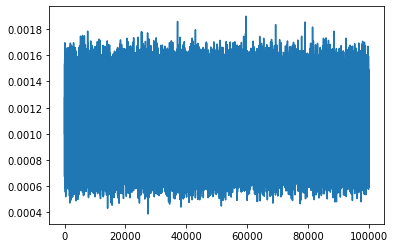

In [258]:
plt.plot(expectedreturn)

In [259]:
maxindex = np.where(sharpeRatio == sharpeRatio.max())
maxindex

(array([59581], dtype=int64),)

In [260]:
weight[maxindex,:]

array([[[0.02855814, 0.0117526 , 0.02949556, 0.00974712, 0.01400244,
         0.0164114 , 0.00450336, 0.00304493, 0.00744966, 0.01440402,
         0.01907359, 0.01662339, 0.02471652, 0.00411692, 0.00588474,
         0.00681901, 0.00071804, 0.0035011 , 0.01227292, 0.00374367,
         0.0133339 , 0.01962686, 0.00363069, 0.01260214, 0.02779424,
         0.00912809, 0.01438763, 0.02542256, 0.03148613, 0.01662897,
         0.00193769, 0.01369267, 0.01770298, 0.00606876, 0.01735841,
         0.01510772, 0.00231091, 0.00956221, 0.01382318, 0.01353144,
         0.00631699, 0.00436431, 0.00202692, 0.02005334, 0.00658211,
         0.00016406, 0.01590782, 0.00918109, 0.00290427, 0.02434528,
         0.02311107, 0.0210506 , 0.0063695 , 0.02252405, 0.01002115,
         0.00889642, 0.01827035, 0.00702004, 0.03010288, 0.0006734 ,
         0.01198485, 0.03138488, 0.00711363, 0.00714758, 0.00440472,
         0.02907859, 0.01148007, 0.00714336, 0.00188584, 0.02943253,
         0.00715199, 0.01177826, 0

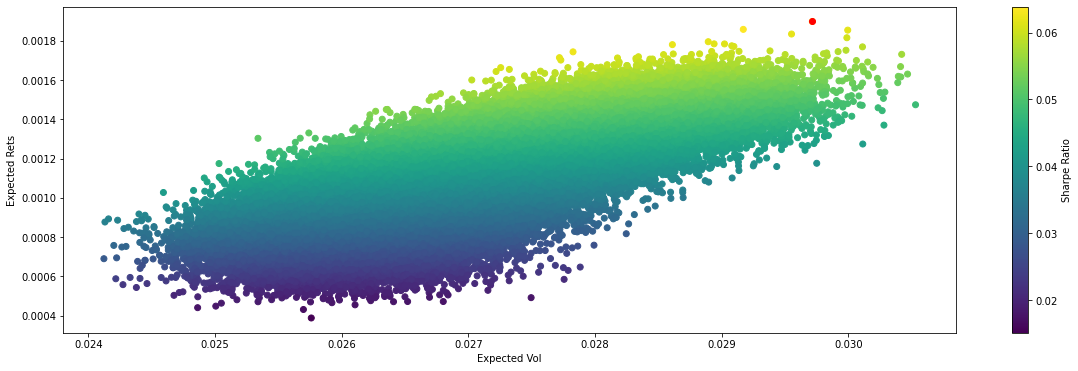

In [261]:
plt.figure(figsize=(20,6))
plt.scatter(expectedvol,expectedreturn,c=sharpeRatio)
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Expected Vol')
plt.ylabel('Expected Rets')
plt.scatter(expectedvol[maxindex],expectedreturn[maxindex], c = 'red')
plt.show()

In [143]:
import scipy

In [262]:
from scipy.optimize import minimize

def negativeSR(w):
    w = np.array(w)
    R = np.sum(mean_returns*w)
    V = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    SR = R/V
    return -1*SR

def checksumtoone(w):
    return np.sum(w)-1
w0 = np.full((len(precos.columns)), 1/len(precos.columns)) #chute pesos (tudo igual)

#Limitando não poder ficar short (pesos entre 0 e 1)
a = [(0,1)]
for i in range (2,(len(precos.columns))+1):
    a.append((0,1))
a = tuple(a) 

bounds = (a)
constraints = ({'type':'eq','fun':checksumtoone})
w_opt = minimize(negativeSR,w0,method = 'SLSQP',bounds = bounds, constraints = constraints)
w_opt

     fun: -0.12322753535895682
     jac: array([ 3.73070259e-02,  7.68183358e-02,  3.89565183e-02,  7.99598880e-02,
        5.79476031e-02,  5.47855133e-02,  5.94926374e-02,  5.50655397e-02,
        1.07141584e-03, -2.10978091e-04,  3.79718095e-02,  5.08411545e-02,
       -1.14381313e-04,  7.72633385e-02,  6.11240435e-02,  9.94830439e-02,
        3.16154156e-02,  1.21252649e-01,  4.61007347e-02,  4.62937001e-02,
        2.95830946e-02,  1.82081573e-02, -4.57661226e-05,  7.14773536e-02,
        6.41107485e-02,  5.93175404e-02,  4.05865833e-02,  3.10129253e-02,
        2.87846308e-02,  3.54710212e-02,  3.77105903e-02,  1.36401504e-05,
        3.43296379e-02,  2.00393638e-02,  7.97646819e-02,  4.08003815e-02,
        2.67448435e-02,  2.82202223e-02,  3.04786256e-02,  9.16985245e-02,
        2.80025760e-02,  3.67203215e-02,  3.23528070e-02,  4.86516962e-02,
        1.45851796e-01,  4.71872119e-02,  4.63345880e-02,  3.32362568e-02,
        2.50975443e-02,  1.31279230e-05,  5.98067855e-02,  

In [263]:
w_opt.x

array([0.00000000e+00, 0.00000000e+00, 4.41987547e-16, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.81003922e-17,
       6.93550316e-17, 8.36622489e-03, 1.47752715e-17, 0.00000000e+00,
       4.94966029e-02, 0.00000000e+00, 0.00000000e+00, 1.14426980e-16,
       0.00000000e+00, 0.00000000e+00, 1.25562980e-16, 2.05533419e-17,
       0.00000000e+00, 2.97538641e-17, 3.58349199e-01, 0.00000000e+00,
       1.38461811e-16, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.39325449e-17, 7.96247024e-17, 6.22594892e-17, 2.11510647e-02,
       2.91293545e-17, 9.15176607e-17, 0.00000000e+00, 1.37165093e-17,
       0.00000000e+00, 1.42820378e-16, 0.00000000e+00, 1.55643959e-17,
       2.14613153e-17, 5.15922991e-17, 0.00000000e+00, 0.00000000e+00,
       1.06573509e-16, 0.00000000e+00, 5.88853193e-17, 1.38412904e-17,
       0.00000000e+00, 3.91778448e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.83726162e-17, 5.59390677e-02, 1.20475284e-17,
      

In [274]:
returns = np.linspace(0.0002,0.002,50)
volatility_opt = []

def minimizevol(w):
    w = np.array(w)
    V = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    return V
def getreturn(w):
    w = np.array(w)
    R = np.sum(mean_returns*w)
    return R
for R in returns:
    constraints = ({'type':'eq','fun':checksumtoone},
                  {"type":'eq','fun': lambda w: getreturn(w) - R})
    opt = minimize(minimizevol,w0,method = 'SLSQP',bounds = bounds, constraints = constraints)
    volatility_opt.append(opt['fun'])

In [275]:
len(volatility_opt)

50

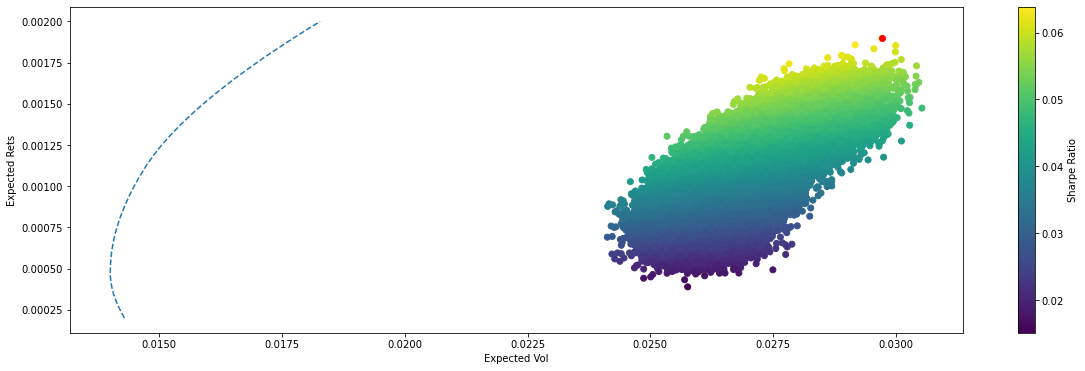

In [276]:
plt.figure(figsize=(20,6))
plt.scatter(expectedvol,expectedreturn,c=sharpeRatio)
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Expected Vol')
plt.ylabel('Expected Rets')
plt.scatter(expectedvol[maxindex],expectedreturn[maxindex], c = 'red')
plt.plot(volatility_opt,returns,'--')
plt.show()

In [277]:
df = pd.DataFrame({'Ativos':["ABEV3.SA" , "AZUL4.SA" , "B3SA3.SA" , "BBAS3.SA" , "BBDC3.SA",  "BBDC4.SA" , "BBSE3.SA" , "BEEF3.SA", 
"BPAC11.SA", "BRAP4.SA" , "BRDT3.SA" , "BRFS3.SA" , "BRKM5.SA" , "BRML3.SA" , "CCRO3.SA" , "CIEL3.SA" ,
"CMIG4.SA"  ,"COGN3.SA" , "CPFE3.SA" , "CPLE6.SA" , "CRFB3.SA" , "CSAN3.SA" , "CSNA3.SA" , "CVCB3.SA" , "CYRE3.SA" ,
"ECOR3.SA"  ,"EGIE3.SA" , "ELET3.SA" , "ELET6.SA", "EMBR3.SA" , "ENBR3.SA" , "ENEV3.SA" , "ENGI11.SA", "EQTL3.SA" ,
"EZTC3.SA"  ,"FLRY3.SA" , "GGBR4.SA" , "GNDI3.SA" , "GOAU4.SA" , "GOLL4.SA" , "HAPV3.SA" , "HGTX3.SA" , "HYPE3.SA" ,
"IGTA3.SA"  ,"IRBR3.SA" , "ITSA4.SA" , "ITUB4.SA" , "JBSS3.SA" , "JHSF3.SA" , "KLBN11.SA", "LAME4.SA" , "LCAM3.SA" ,
"LREN3.SA"  ,"MGLU3.SA" , "MRFG3.SA" , "MRVE3.SA" , "MULT3.SA" , "NTCO3.SA" , "PCAR3.SA" , "PETR3.SA" , "PETR4.SA" ,
"PRIO3.SA"  ,"QUAL3.SA" , "RADL3.SA" , "RAIL3.SA" , "RENT3.SA" , "SANB11.SA", "SBSP3.SA" , "SULA11.SA", "SUZB3.SA" ,
"TAEE11.SA" , "TOTS3.SA" , "UGPA3.SA" , "USIM5.SA" , "VALE3.SA" , "VIVT3.SA" ,  "WEGE3.SA" ,"YDUQ3.SA"], 'Peso otimo':w_opt.x})

In [278]:
df.sort_values(by = 'Peso otimo', ascending = False)

,Ativos,Peso otimo
22,CSNA3.SA,0.358349
69,SUZB3.SA,0.178010
71,TOTS3.SA,0.083914
58,PCAR3.SA,0.066617
54,MRFG3.SA,0.055939
...,...,...
42,HYPE3.SA,0.000000
43,IGTA3.SA,0.000000
45,ITSA4.SA,0.000000
48,JHSF3.SA,0.000000


In [279]:
ndf = df.nlargest(10, 'Peso otimo')


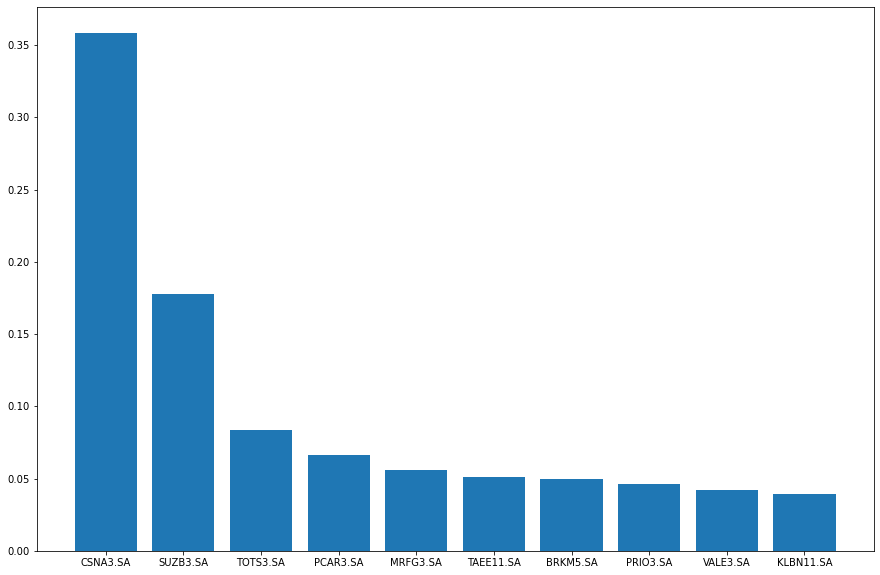

In [280]:
x_pos = np.arange(len(ndf["Ativos"]))

plt.figure(figsize=(15,10))

plt.bar(ndf["Ativos"],ndf['Peso otimo'])

# Create names on the x-axis
plt.xticks(x_pos, ndf["Ativos"])

# Show graph
plt.show()